<a href="https://colab.research.google.com/github/Stone-bridge-NLP/BERT/blob/main/GenreClassification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting environment

In [1]:
# required packages to use BERT via hub models
%%bash
pip install tqdm boto3 requests regex sentencepiece sacremoses

  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
# additional packages required (to avoid error, not mentioned in the tutorial)
!pip install huggingface_hub
!pip install tokenizers

     |████████████████████████████████| 59 kB 2.9 MB/s 
     |████████████████████████████████| 3.3 MB 4.2 MB/s 


In [3]:
# download shared dataset to local disk
!gdown --id 1TGpLOsptZ2hv0GFfK5cqzO33xJAYT2si

Downloading...
From: https://drive.google.com/uc?id=1TGpLOsptZ2hv0GFfK5cqzO33xJAYT2si
To: /content/train_filtered.csv
100% 318M/318M [00:01<00:00, 251MB/s]


# Train model

In [4]:
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
train_dataset = pd.read_csv('/content/train_filtered.csv')
print(train_dataset)

                  Artist  ...                                             Lyrics
0              12 stones  ...  It starts with pain, followed by hate\nFueled ...
1              12 stones  ...  Freedom!\nAlone again again alone\nPatiently w...
2              12 stones  ...  Biting the hand that feeds you, lying to the v...
3              12 stones  ...  You say you know just who I am\nBut you can't ...
4              12 stones  ...  My heart is beating faster can't control these...
...                  ...  ...                                                ...
249943      bobby womack  ...  I'm the best friend he's got I'd give him the ...
249944     bad boys blue  ...  Bad Boys Blue "I Totally Miss You" I did you w...
249945       celine dion  ...  Forgive me for the things That I never said to...
249946          dan bern  ...  The day they found a cure for AIDS The day the...
249947  crawdad republic  ...  Fourth of July has come, it's custom that we g...

[249948 rows x 5 columns]


In [6]:
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
portion = len(train_dataset)//(10*1) # 10 classes, 1/1th of dataset
equal_td = []
train_dataset = train_dataset[['Genre', 'Lyrics']]
for genre in genre_id2name:
  td = train_dataset[train_dataset['Genre'] == genre]
  equal_td.append(td.sample(n=portion,replace=True))
  print(f'{genre}\t sample ratio\t {len(td)}:{portion}')
  
td = pd.concat(equal_td).reset_index().drop(columns=['index'])

Electronic	 sample ratio	 2002:24
Country	 sample ratio	 1890:24
R&B	 sample ratio	 2763:24
Jazz	 sample ratio	 13314:24
Indie	 sample ratio	 7240:24
Pop	 sample ratio	 86219:24
Folk	 sample ratio	 8165:24
Metal	 sample ratio	 19098:24
Hip-Hop	 sample ratio	 2238:24
Rock	 sample ratio	 107019:24


In [7]:
class LyricsAndGenreDataset(Dataset):
  def __init__(self, dataframe, tokenizer, num_sentence):
    self.df = dataframe
    self.tk = tokenizer
    self.num_sentence = num_sentence
    self.genre_name2id = {
        'Electronic':0, 
        'Country':1, 
        'R&B':2, 
        'Jazz':3, 
        'Indie':4, 
        'Pop':5, 
        'Folk':6, 
        'Metal':7, 
        'Hip-Hop':8, 
        'Rock':9}

  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()

    genre = self.genre_name2id[self.df['Genre'][idx]]
    lyric = [self.df['Lyrics'][idx]]

    with torch.no_grad():
      indexed_tokens = self.tk.batch_encode_plus(
            lyric, add_special_tokens=True, padding= 'max_length', 
            max_length=2**9*self.num_sentence, truncation=True)
      
      tk_tensor = torch.tensor(indexed_tokens['input_ids']).view(-1,2**9)
      sg_tensor = torch.tensor(indexed_tokens['token_type_ids']).view(-1,2**9)

    return genre, tk_tensor, sg_tensor



In [8]:
class myLSTM(nn.Module):
  def __init__(self, input_size, hidden_size,num_layers,dropout, batch_first):
    super(myLSTM, self).__init__()

    self.layer = nn.LSTM(
                    input_size=input_size,
                    hidden_size=hidden_size,
                    num_layers=num_layers,
                    dropout=dropout,
                    batch_first=batch_first)
    
  def forward(self, x, hidden):
    # _, hidden = x
    output, _ = self.layer(x, hidden)
    return output, hidden

In [9]:
class TextLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, n_class, dropout):
    super(TextLSTM, self).__init__()

    # dim = np.linspace(input_size, hidden_size,num_layers+1).astype(np.int32)
    # lstm_stack = []
    # for i in range(len(dim)-1):
    #   lstm_stack.append(
    #       nn.LSTM(
    #           input_size=dim[i],
    #           hidden_size=dim[i+1],
    #           num_layers=1,
    #           dropout=dropout,
    #           batch_first=True)
    #   )
    
    # self.lstm = nn.Sequential(*lstm_stack)
    
    self.lstm = nn.LSTM(
              input_size=input_size,
              hidden_size=hidden_size,
              num_layers=num_layers,
              dropout=dropout,
              batch_first=True)

    self.dense = nn.Sequential(
        nn.ReLU(),
        nn.Linear(hidden_size, n_class),
        nn.Softmax(dim=1))

  def forward(self, hidden_and_cell, X):
    X = X.transpose(0, 1)
    #print(X.shape)
    outputs, hidden = self.lstm(X, hidden_and_cell)
    outputs = outputs[-1]  # 최종 예측 Hidden Layer
    return self.dense(outputs)

In [10]:
#### hyperparameters ####
epoch = 2
lr = 0.0001
batch_size = 4
num_sentences = 2 # one sentence has 512 tokens
hidden_size = 128
num_layers = 4
dropout = 0

# fixed
v_dim = 768
n_genre = 10
genre_id2name = ['Electronic', 'Country', 'R&B', 'Jazz', 'Indie', 'Pop', 'Folk', 'Metal', 'Hip-Hop', 'Rock']
genre_name2id = {'Electronic':0, 'Country':1, 'R&B':2, 'Jazz':3, 'Indie':4, 'Pop':5, 'Folk':6, 'Metal':7, 'Hip-Hop':8, 'Rock':9}
device = torch.device('cuda') if (torch.cuda.is_available())else torch.device('cpu')

In [15]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')
bert_embedding = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased').to(device)

dset = LyricsAndGenreDataset(td,tokenizer,num_sentences)
split_size = [
              int(0.7*0.8*len(dset)),
              int(0.7*0.2*len(dset)),
              len(dset)-int(0.7*0.8*len(dset))-int(0.7*0.2*len(dset))]
train_set, val_set, test_set = torch.utils.data.random_split(dset,split_size)

train_loader = DataLoader(train_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
val_loader = DataLoader(val_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)
test_loader = DataLoader(test_set,batch_size=batch_size, shuffle=True, 
                          num_workers=0, drop_last=True)

lstm_classifier = TextLSTM(v_dim, hidden_size, num_layers, n_genre, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
params = list(lstm_classifier.parameters())
optimizer = optim.Adam(params, lr=lr)

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_master
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassificati

In [16]:
train_loss_list = []
val_loss_list = []

for e in range(epoch):
  for b,batch in enumerate(train_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)

    with torch.no_grad():
      embedding = bert_embedding(tk_batch.view(-1,2**9), token_type_ids= sg_batch.view(-1,2**9))

    embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

    hidden = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    cell = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    output = lstm_classifier.forward((hidden, cell), embedded_tokens)
    optimizer.zero_grad()
    loss = loss_func(output, label_batch)
    loss.backward()
    optimizer.step()
    
    if b%4 == 0:
      print(f'\rTRAIN: epoch {e} batch {b} loss {loss.data}', end='\t')
      train_loss_list.append(float(loss.detach().cpu().data))


  for b,batch in enumerate(val_loader):
    label_batch = batch[0].to(device)
    tk_batch = batch[1].to(device)
    sg_batch = batch[2].to(device)

    with torch.no_grad():
      embedding = bert_embedding(tk_batch.view(-1,2**9), token_type_ids= sg_batch.view(-1,2**9))

    embedded_tokens = embedding[0].view(batch_size,2**9*num_sentences,-1)

    hidden = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    cell = torch.zeros(
          num_layers,embedded_tokens.shape[1],hidden_size, requires_grad=True,device=device)
    output = lstm_classifier.forward((hidden, cell), embedded_tokens)
    optimizer.zero_grad()
    loss = loss_func(output, label_batch)
    loss.backward()
    optimizer.step()
    
    print(f'\rVAL: epoch {e} batch {b} loss {loss.data}', end='\t')
    val_loss_list.append(float(loss.detach().cpu().data))

VAL: epoch 1 batch 7 loss 2.3024635314941406	

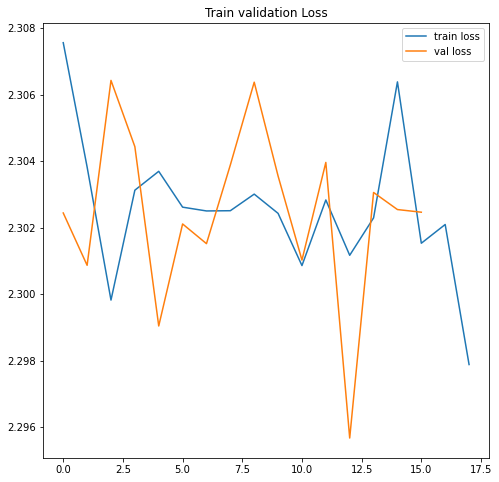

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.title('Train validation Loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='val loss')
plt.legend()
plt.show()